<font face='candara' size=12><center><b>Churn Prediction for Telecoms Business</b></center></font>

## Task 1:<br>Formulate and articulate the problem(s) to be solved

## Skills:<br>Domain knowledge and/or access to stakeholder's business subject matter experts

## To Do:<ul><li>What question/problem does the stakeholder need you to answer?<li>Formulate the question so that it can be answered with data. <li>What outcome(s) does the stakeholder hope for?<li>What are the stakeholer's business processes/operations?<li>How do they measure the success?<li>etc.

### Business Case Overview:
####  - The business spends a lot of money on targeted advertising, promotions and other activities aimed at customer retention.
####  - They would like to know which customers are likely to cancel their subscriptions
####  - They would also like to know what factors drive customer churn
####  - This will enable them to save money on customer retention activities targeting these specific customers
####  - They could also, possibly, be able to reach "at-risk" customers before they churn
####  - The business is particularly concerned about false negatives (i.e. classifying customers as NOT churning who will churn)
####  - The business is not as concerned about false positives (i.e. classifying customers as churning who will NOT churn)

In [1]:
%reset -f

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, plot_confusion_matrix

from collections import Counter, defaultdict

import psutil

from colorama import Style, Fore, Back

## Task 2:<br>Identify the data needed to answer these questions

## Skills:<br>Access to the data and the ability to retrieve it (e.g. SQL, pyodbc, Excel, flat file manipulation, etc.)

## To Do:<ul><li>Is there data and enough of it?<li>Is the data accessible?<li>Is the data relevant?<li>Is the data complete?<li>Is the data representative of the problem or is it imbalanced?<li>etc.

In [3]:
df = pd.read_csv('churn_data.csv')

# merge "Area Code" and "Phone" fields to get complete phone numbers...then drop the "Area Code" field
df['Phone'] = [str(i)+'-'+j for i,j in zip(df['Area Code'],df['Phone'])]
df = df.drop(['Area Code'], axis=1)

df.head()

,Account Length,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,Churn,Int'l Plan,VMail Plan,Day Calls,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,State,Phone
0,128,25,265.1,197.4,244.7,10.0,1,0,0,1,110,45.07,99,16.78,91,11.01,3,2.70,KS,415-382-4657
1,107,26,161.6,195.5,254.4,13.7,1,0,0,1,123,27.47,103,16.62,103,11.45,3,3.70,OH,415-371-7191
2,137,0,243.4,121.2,162.6,12.2,0,0,0,0,114,41.38,110,10.30,104,7.32,5,3.29,NJ,415-358-1921
3,84,0,299.4,61.9,196.9,6.6,2,0,1,0,71,50.90,88,5.26,89,8.86,7,1.78,OH,408-375-9999
4,75,0,166.7,148.3,186.9,10.1,3,0,1,0,113,28.34,122,12.61,121,8.41,3,2.73,OK,415-330-6626


In [4]:
df.shape

(3333, 20)

In [5]:
# function to display UNIQUE examples of data in each field

def getDesc(df, thisFt, numExamples=5):
    x = list(set([i for i in df[thisFt] if i==i]))
    if len(x)<numExamples:
        numExamples = len(x)
    x = list(np.random.choice(x, size=numExamples, replace=False))
    print('Examples in '+Style.BRIGHT+thisFt+':'+Style.RESET_ALL, x, '\n')
    return None

# ======================================================================================

# function to display the number of missing values in each field

def getNumNan(df, thisFeature):
    ms = df[df[thisFeature] != df[thisFeature]].shape[0]
    print('Missing values in '+Style.BRIGHT+thisFeature+Style.RESET_ALL+': {}'.format(ms))
    return None

In [6]:
labelSkew = Counter(df['Churn'])

for i in labelSkew.keys():
    if i==0:
        s = 'Not_Churned'
    else:
        s = 'Churned'
    thisCount = round(100*labelSkew[i]/df.shape[0],1)
    print(s+':', thisCount, '%')

Not_Churned: 85.5 %
Churned: 14.5 %


In [7]:
for i in df.columns:
    getNumNan(df,i)
    getDesc(df,i)

Missing values in Account Length: 0
Examples in Account Length: [158, 24, 4, 125, 28] 

Missing values in VMail Message: 0
Examples in VMail Message: [51, 29, 45, 43, 41] 

Missing values in Day Mins: 0
Examples in Day Mins: [305.1, 234.8, 146.5, 183.6, 294.2] 

Missing values in Eve Mins: 0
Examples in Eve Mins: [246.9, 101.3, 210.3, 287.6, 263.4] 

Missing values in Night Mins: 0
Examples in Night Mins: [264.2, 216.0, 192.7, 181.1, 231.7] 

Missing values in Intl Mins: 0
Examples in Intl Mins: [3.9, 17.2, 9.6, 11.1, 18.2] 

Missing values in CustServ Calls: 0
Examples in CustServ Calls: [6, 4, 1, 7, 0] 

Missing values in Churn: 0
Examples in Churn: [0, 1] 

Missing values in Int'l Plan: 0
Examples in Int'l Plan: [0, 1] 

Missing values in VMail Plan: 0
Examples in VMail Plan: [0, 1] 

Missing values in Day Calls: 0
Examples in Day Calls: [73, 112, 61, 79, 58] 

Missing values in Day Charge: 0
Examples in Day Charge: [28.51, 52.05, 47.04, 21.35, 17.14] 

Missing values in Eve Calls: 

## Task 3:<br>Explore the data

## Skills:<br>Data manipulations skills

## To Do:<ul><li>Is the data structured or unstructured?<li>What fields exist in the (structured) data?<li>Are there outliers? (e.g. patient_age=250)<li>Are there strong correlations between any two fields? (e.g. call_duration and call_charge)<li>What data types exist in each field?<li>Can new features/fields be engineered? (e.g. evaluate age given birth_date)<li>etc.

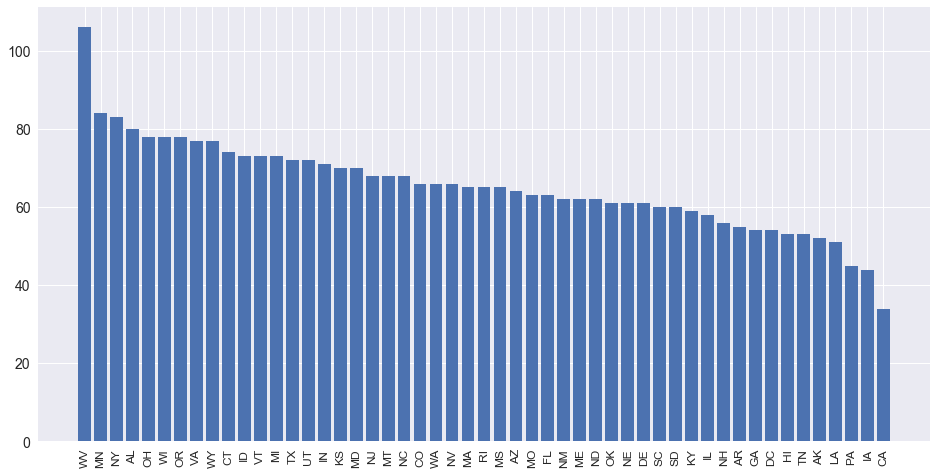

In [8]:
# check customer distribution by state of residence

stateDist = Counter(df['State']).most_common()
px = [i[0] for i in stateDist]
py = [i[1] for i in stateDist]

plt.figure(figsize=[16,8])
plt.bar(px, py)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=14)
plt.show()

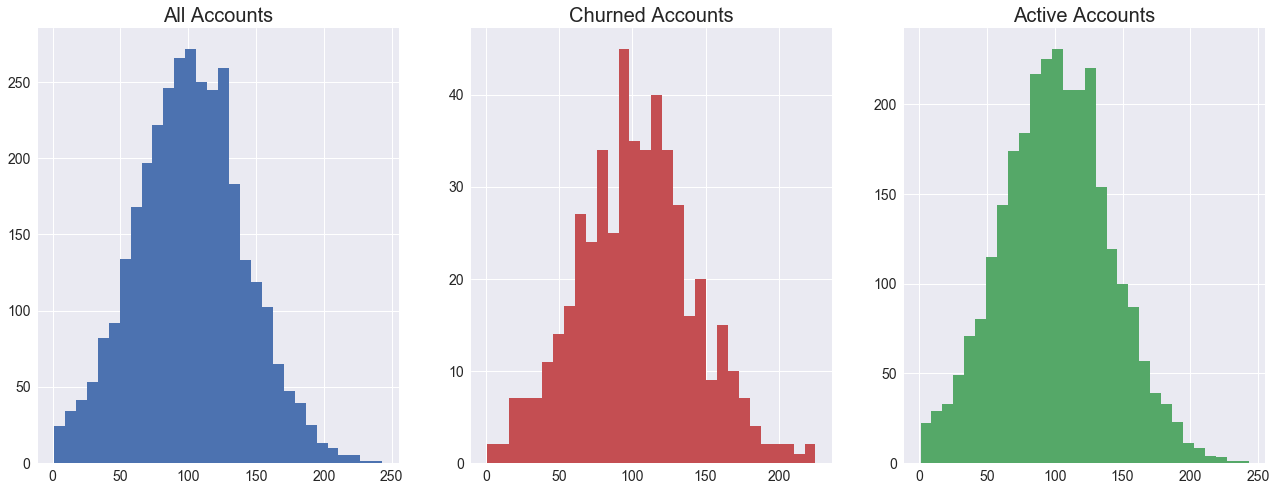

In [9]:
# check distribution of account lengths

px1 = df['Account Length']
px2 = df[df['Churn']==1]['Account Length']
px3 = df[df['Churn']==0]['Account Length']

plt.figure(figsize=[22,8])
plt.subplot(1,3,1)
plt.hist(px1, bins=30)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('All Accounts', fontsize=20)
plt.subplot(1,3,2)
plt.hist(px2, bins=30, color='C2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Churned Accounts', fontsize=20)
plt.subplot(1,3,3)
plt.hist(px3, bins=30, color='C1')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Active Accounts', fontsize=20)
plt.show()

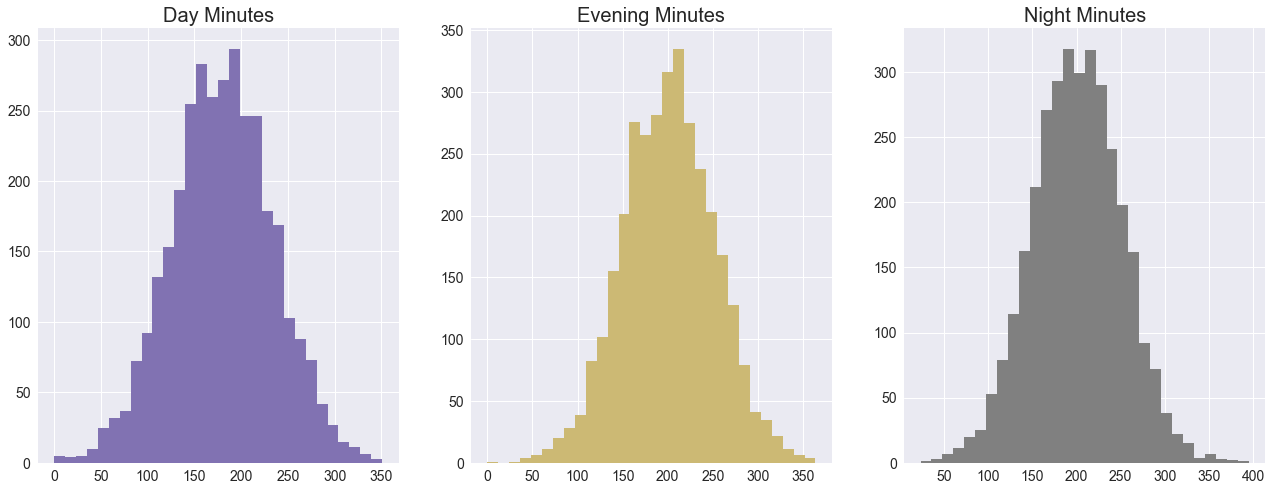

In [10]:
# check distribution of call durations

px1 = df['Day Mins']
px2 = df['Eve Mins']
px3 = df['Night Mins']

plt.figure(figsize=[22,8])
plt.subplot(1,3,1)
plt.hist(px1, bins=30, color='C3')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Day Minutes', fontsize=20)
plt.subplot(1,3,2)
plt.hist(px2, bins=30, color='C4')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Evening Minutes', fontsize=20)
plt.subplot(1,3,3)
plt.hist(px3, bins=30, color='grey')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Night Minutes', fontsize=20)
plt.show()

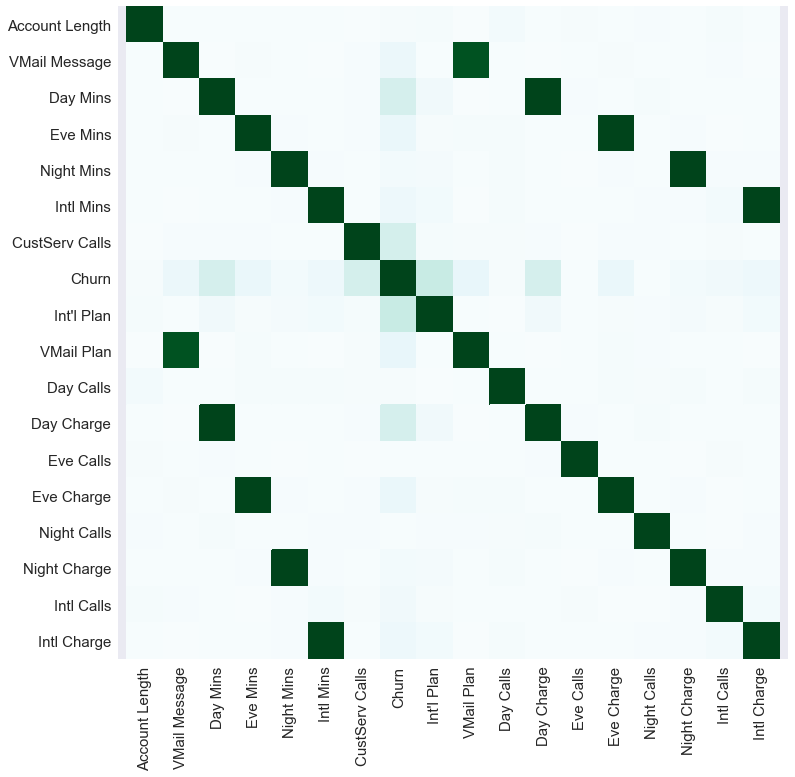

In [11]:
#evaluate correlations

plt.figure(figsize=[12,12])
sns.heatmap(np.abs(df.corr()), cmap='BuGn', cbar=False)
plt.axis('equal')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

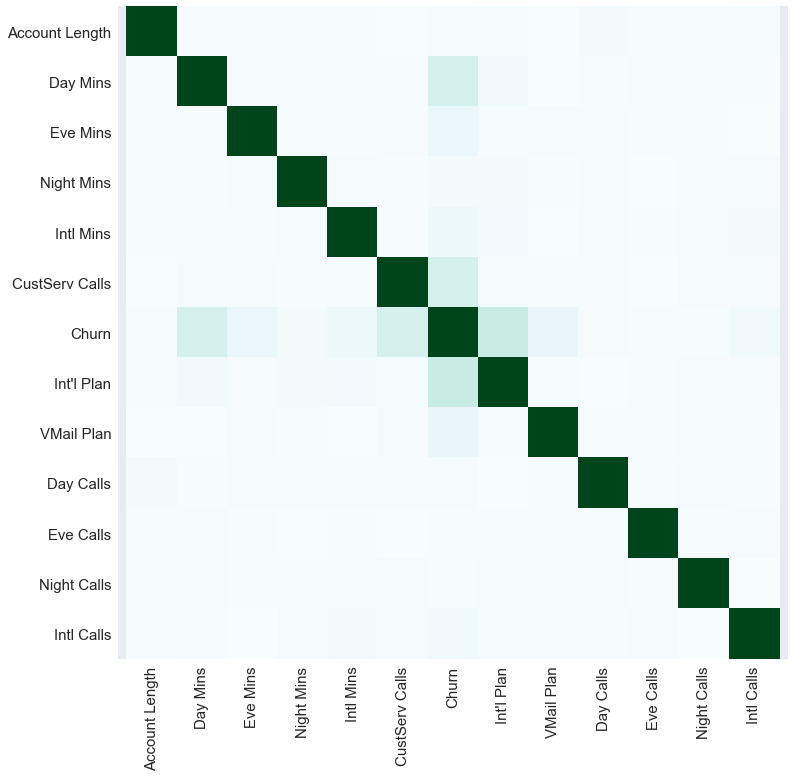

In [12]:
# drop correlated fields and re-evaluate correlations

tdf = df.drop(['VMail Message', 'Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)

plt.figure(figsize=[12,12])
sns.heatmap(np.abs(tdf.corr()), cmap='BuGn', cbar=False)
plt.axis('equal')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Task 4:<br>Select and build model

## Skills:<br>Machine learning knowledge and skills

## To Do:<ul><li>What kind of technique best suits the problem?<li>Does the data need to be further transformated? (e.g. encoding)<li>Can the results of the model be easily explained if necessary?<li>Choose the most suitable technique...not just the coolest or newest one<li><u>ALWAYS</u> test and evaluate the performance of your model<li>Does the model generalize well to new/unseen data? ***<li>etc.

In [13]:
drop_Target = ['Churn']
# drop_Useless = ['Phone', 'State', 'Area Code']
drop_Useless = ['Phone', 'State']
drop_Collinearity = ['VMail Message', 'Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge']

toDrop = drop_Target + drop_Useless + drop_Collinearity

X = df.drop(toDrop, axis=1)
shapeBefore = X.shape
X = pd.get_dummies(X)
shapeAfter = X.shape

y = df['Churn']

theCols = X.columns

print('Shape Before Encoding:', shapeBefore)
print('Shape After Encoding:', shapeAfter)

X_train, X_test, y_train, y_test = train_test_split(X,y)

# X_train.shape, X_test.shape, y_train.shape, y_test.shape

Shape Before Encoding: (3333, 12)
Shape After Encoding: (3333, 12)


In [14]:
#function to evaluate the "False Negative Rate" metric

def getFalseNegRate(y,yp):
    fn = Counter(zip(y,yp))[(1,0)]/len(list(y))
    return fn

false_neg_rate = make_scorer(getFalseNegRate, greater_is_better=False, needs_proba=False, needs_threshold=False)

In [15]:
numJobs = psutil.cpu_count(logical=False)

# scr = false_neg_rate
scr = 'roc_auc'

baseModel = RandomForestClassifier(class_weight='balanced')

estimatorList = range(50,101,50)
depthList = [2,3,4,5]

hyperParams = {'n_estimators':estimatorList, 'max_depth':depthList}

clf = GridSearchCV(estimator=baseModel, param_grid=hyperParams, cv=3, scoring=scr, n_jobs=numJobs, verbose=1)

best_model = clf.fit(X_train, y_train)

# =========================================================================================

print('\n\nBest parameters for RF\n\t{}\n'.format(best_model.best_params_))

# =========================================================================================

yp_train = best_model.predict(X_train)
yp_test = best_model.predict(X_test)

# =========================================================================================

trainScore = round(best_model.score(X_train, y_train),4)
trainAcc = round(100*accuracy_score(y_train, yp_train),1)
print('\nTrain Score: {}'.format(trainScore))
print('Training Accuracy: {}%'.format(trainAcc))

testScore = round(best_model.score(X_test, y_test), 4)
testAcc = round(100*accuracy_score(y_test, yp_test),1)
print('\nTest Score: {}'.format(testScore))
print('Test Accuracy: {}%'.format(testAcc))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:    9.5s finished




Best parameters for RF
	{'max_depth': 5, 'n_estimators': 100}


Train Score: 0.9451
Training Accuracy: 92.6%

Test Score: 0.9192
Test Accuracy: 91.0%


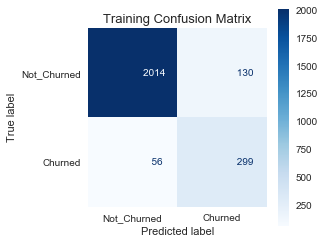

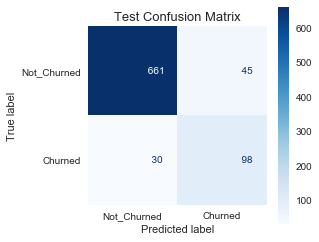

In [16]:
classLabels = ['Not_Churned', 'Churned']

disp = plot_confusion_matrix(estimator=best_model.best_estimator_, X=X_train, y_true=y_train, cmap='Blues', values_format='20.0f', display_labels=classLabels)
disp.figure_.set_size_inches(w=4, h=4)
disp.ax_.set_title('Training Confusion Matrix', fontsize=13)
plt.grid()

disp = plot_confusion_matrix(estimator=best_model.best_estimator_, X=X_test, y_true=y_test, cmap='Blues', values_format='20.0f', display_labels=classLabels)
disp.figure_.set_size_inches(w=4, h=4)
disp.ax_.set_title('Test Confusion Matrix', fontsize=13)
plt.grid()

plt.show()

## Task 5:<br>Communicate the results (or deploy the model into production)

## Skills:<br>Communication/Storytelling skills

## To Do:<ul><li>Target audience is most likely the executives?<li>Avoid temptation to use DS jargon; communicate to them in their language<li>Be sure to address the problem you set out to solve<li>etc.

In [17]:
theImps = sorted(zip(theCols, best_model.best_estimator_.feature_importances_), key=lambda x:x[1], reverse=True)

tuplesFeaturePolarity = []

for i in theImps:
    thisCorr = np.corrcoef(X[i[0]], y)[1,0]
    thisCorr = round(thisCorr,3)
#     print((i[0], thisCorr))
    if thisCorr>=0:
        thisPolarity = 'DRIVES UP'
    else:
        thisPolarity = 'DRIVES DOWN'
    tuplesFeaturePolarity.append( (i[0], round(100*i[1],2), thisPolarity) )

impDF = pd.DataFrame(tuplesFeaturePolarity, columns=['Feature', 'Importance (%)', 'Direction'])
impDF[['Feature', 'Importance (%)']]

,Feature,Importance (%)
0,Day Mins,30.04
1,CustServ Calls,24.51
2,Int'l Plan,14.83
3,Eve Mins,7.20
4,VMail Plan,4.40
5,Intl Mins,4.34
6,Night Mins,3.80
7,Intl Calls,3.23
8,Day Calls,2.04
9,Account Length,2.00


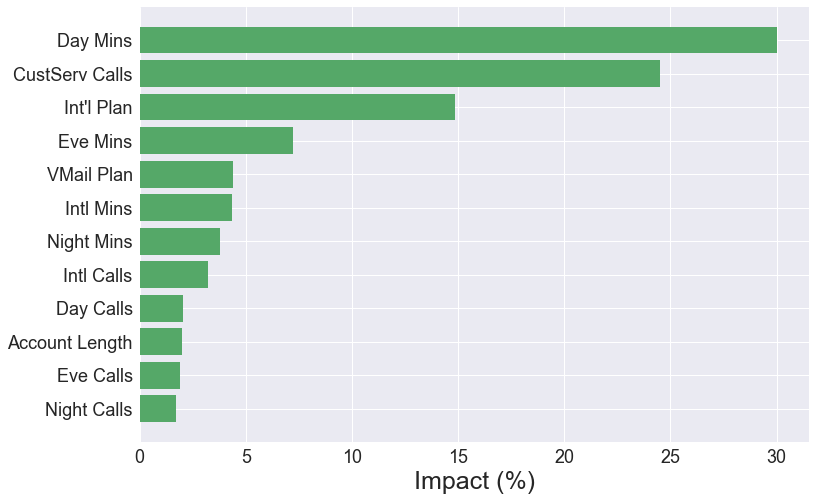

In [18]:
px = impDF['Feature']
py = impDF['Importance (%)']

plt.figure(figsize=[12,8])
plt.barh(px, py, color='C1')
plt.gca().invert_yaxis()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Impact (%)', fontsize=25)
plt.show()

# CONCLUSION
## PRACTICE is the surest way to improve these skills and become more confident<li>Get your hands dirty<li>Don't be afraid to get the wrong answer (but avoid fudging at all cost)<li>Two heads are better than one (teamwork and collaboration)<li>Don't reinvent the wheel. Use well tested libraries when possible


# FINAL MESSAGE:<br>Data Science is a toolbox...<br>Once a problem has been CLEARLY DEFINED, reach into the toolbox to select the tools you need to solve it.

In [27]:
### review of one hot encoding

# df = pd.DataFrame()

# theCities = ['City_1', 'City_2', 'City_3']

# df['City'] = [np.random.choice(theCities) for i in range(10)]
# df['Price'] = np.random.uniform(10, 100, [10,]).round(2)
# # df['City_Tag'] = [int(i.split('_')[-1]) for i in df['City']]

# df

# pd.get_dummies(df)